In [198]:
#Imports
import pandas as pd
import QuantLib as ql
import glob
import os
import statsmodels.api as sm

In [199]:
#Reading and adjusting ESTR
estr = pd.read_csv('estr/estr_daily_rates.csv', parse_dates=['DATE'])
estr['ql_date'] = estr['DATE'].apply(ql.Date().from_date)
estr['estr_pct'] = estr.iloc[:, 2]/100
estr.describe()

,DATE,Euro short-term rate - Volume-weighted trimmed mean rate (EST.B.EU000A2X2A25.WT),estr_pct
count,1413,1413.000000,1413.000000
mean,2022-07-02 11:57:27.133758208,1.135695,0.011357
min,2019-10-01 00:00:00,-0.593000,-0.005930
25%,2021-02-17 00:00:00,-0.564000,-0.005640
50%,2022-07-01 00:00:00,-0.532000,-0.005320
75%,2023-11-14 00:00:00,3.165000,0.031650
max,2025-04-03 00:00:00,3.913000,0.039130
std,NaN,1.909901,0.019099


In [200]:
def read_until_blank(filepath):
    with open(filepath, "r") as f:
        lines = []
        for line in f:
            if line.strip() == "":  # Stop at first empty line
                break
            lines.append(line)

    from io import StringIO
    return pd.read_csv(StringIO("".join(lines)))

#Reading and adjusting EURIBOR
csv_files = glob.glob(os.path.join('./euribor', '*.csv'))
df_list = [read_until_blank(file) for file in csv_files]
euribor = pd.concat(df_list, ignore_index=True)
euribor.columns = ['euribor_tenor', 'month', 'DATE', 'rate']
euribor = euribor.drop(columns=['month'])
euribor['DATE'] = pd.to_datetime(euribor['DATE'])
euribor = euribor.dropna() #Some missing values in the 3m tenor need to be dropped, only 8 rows
euribor = euribor.pivot(index='DATE', columns='euribor_tenor', values='rate')
euribor = euribor.sort_index()
euribor['3m_pct'] = euribor['3 month'] / 100
euribor.describe()

euribor_tenor,1 month,1 week,12 month,3 month,6 month,3m_pct
count,1394.000000,1394.000000,1394.000000,1386.000000,1394.000000,1386.000000
mean,1.191310,1.172948,1.484471,1.300618,1.396823,0.013006
std,1.877347,1.896371,1.860970,1.885282,1.889810,0.018853
min,-0.648000,-0.602000,-0.518000,-0.605000,-0.554000,-0.006050
25%,-0.547000,-0.563000,-0.432500,-0.510000,-0.485000,-0.005100
50%,-0.211000,-0.444500,1.057500,0.235500,0.631500,0.002355
75%,3.257500,3.282500,3.540750,3.420250,3.427000,0.034202
max,3.895000,3.907000,4.228000,4.002000,4.143000,0.040020


In [201]:
#Compounding function
def compound_estr(daily_rates):
    compounded = 1.0
    for i in range(len(daily_rates) - 1):
        r = daily_rates[i]['estr_pct']
        d1 = daily_rates[i]['ql_date']
        d2 = daily_rates[i+1]['ql_date']
        delta_days = (d2 - d1)
        compounded *= (1 + r * delta_days / 360)
    
    total_days = (daily_rates[-1]['ql_date'] - daily_rates[0]['ql_date'])
    annualized_rate = compounded ** (360 / total_days) - 1
    return annualized_rate

In [202]:
#Compounding ESTR into realized 3m rate
target = ql.TARGET()
last_day_in_data = estr.iloc[-1]['ql_date']

estr_3m_list = []
for row in estr.itertuples():
    today = row[4]
    spot = target.advance(today, ql.Period(2, ql.Days), ql.ModifiedFollowing)
    tenor = ql.Period('3m')
    end_date = target.advance(spot, tenor, ql.ModifiedFollowing)
    if last_day_in_data - spot < 90: #Skip period where we don't have complete ESTR data
        break
    rows_to_compound = estr[(estr['ql_date'] >= spot) &  (estr['ql_date'] <= end_date)]
    estr_3m = compound_estr(rows_to_compound.to_dict(orient='records'))
    estr_3m_list.append(estr_3m)
estr['estr_3m'] = pd.Series(estr_3m_list).reindex(estr.index, fill_value=0)

<Axes: xlabel='DATE'>

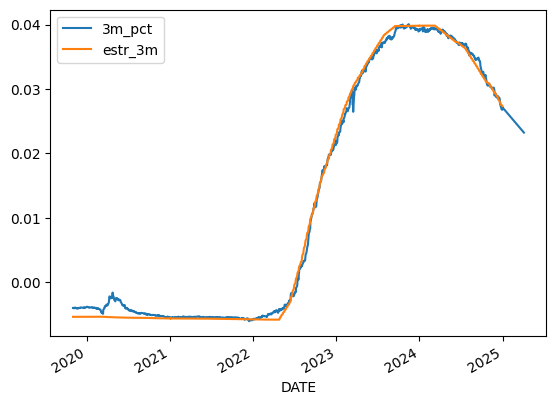

In [203]:
#Preparing for analysis
common = euribor.merge(estr[['DATE', 'estr_3m']], on='DATE', how='left')
common = common[common['estr_3m'] != 0] #Drop rows where ESTR doesn't exist
common.plot(x='DATE', y=['3m_pct', 'estr_3m'])

<Axes: xlabel='DATE'>

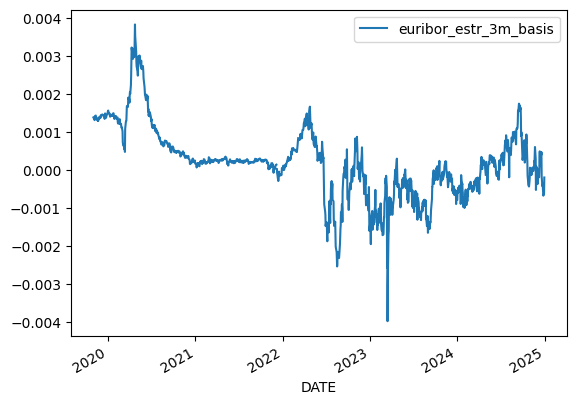

In [204]:
#Plotting diff
common['euribor_estr_3m_basis'] = common['3m_pct'] - common['estr_3m']
common.plot(x='DATE', y='euribor_estr_3m_basis')

In [ ]:
#Simple regression analysis: can today - yday EURIBOR fixing predict tomorrow - today realized ESTR?
common['euribor_3m_diff'] = common['3m_pct'].diff()
common['estr_3m_diff'] = common['estr_3m'].diff()

common['euribor_3m_diff_lag'] = common['euribor_3m_diff'].shift(1)
regression_df = common.dropna(subset=['euribor_3m_diff_lag', 'estr_3m_diff'])

x = regression_df['euribor_3m_diff_lag']
y = regression_df['estr_3m_diff']

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           estr_3m_diff   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     113.3
Date:                lör, 05 apr 2025   Prob (F-statistic):           1.98e-25
Time:                        12:24:10   Log-Likelihood:                 10399.
No. Observations:                1300   AIC:                        -2.079e+04
Df Residuals:                    1298   BIC:                        -2.078e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                2.226e-05   2